In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import skew, zscore

# Les données

In [22]:
df = pd.read_csv("../Data/Data_vf_marketing_campaigns.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Education                 2212 non-null   object 
 1   Marital_Status            2212 non-null   object 
 2   Income                    2212 non-null   float64
 3   Recency                   2212 non-null   int64  
 4   MntWines                  2212 non-null   int64  
 5   MntFruits                 2212 non-null   int64  
 6   MntMeatProducts           2212 non-null   int64  
 7   MntFishProducts           2212 non-null   int64  
 8   MntSweetProducts          2212 non-null   int64  
 9   MntGoldProds              2212 non-null   int64  
 10  NumDealsPurchases         2212 non-null   int64  
 11  NumWebPurchases           2212 non-null   int64  
 12  NumCatalogPurchases       2212 non-null   int64  
 13  NumStorePurchases         2212 non-null   int64  
 14  NumWebVi

In [23]:
data = df[["Education","Age", "Marital_Status", "Income", "Recency", "Seniority", "Is_parent","Household","Total_Spent", "Total_Accepted_Campaigns","Total_purchases"]].copy()
display(data.head())


,Education,Age,Marital_Status,Income,Recency,Seniority,Is_parent,Household,Total_Spent,Total_Accepted_Campaigns,Total_purchases
0,Graduation,57,Single,58138.0,58,663,Not Parent,1,1617,0,25
1,Graduation,60,Single,46344.0,38,113,Parent,3,27,0,6
2,Graduation,49,Together,71613.0,26,312,Not Parent,2,776,0,21
3,Graduation,30,Together,26646.0,26,139,Parent,3,53,0,8
4,PostGraduation,33,Together,58293.0,94,161,Parent,3,422,0,19


## 1.1 Préparation des données pour la segmentation

Les étapes de prétraitement suivantes seront appliquées aux données afin de les préparer pour l'analyse :

1. **Encodage des Variables Catégorielles** :
   - Les variables **"Education"**, **"Marital_Status"**, et **"Is_parent"** seront encodées en utilisant la méthode **One-Hot Encoding**. Cette transformation permet de convertir ces variables catégorielles en variables binaires (0 ou 1), en supprimant la première catégorie de chaque variable pour éviter la multicolinéarité.

2. **vérication de l'asymétrie des variables numériques et Standardisation** :
   - L'asymétrie (skewness) des variables numériques sera évaluée pour déterminer si une transformation est nécessaire. Ensuite, les variables seront standardisées à l'aide de StandardScaler. Cela garantit que toutes les variables sont sur une échelle comparable, avec une moyenne de 0 et une variance de 1, évitant ainsi qu'une variable à forte amplitude n'influence de manière disproportionnée les analyses ultérieures.

3. **Détection et Suppression des Valeurs Aberrantes** :
   - Les valeurs aberrantes seront identifiées en calculant le **score Z** pour chaque observation. Les clients avec un score Z absolu supérieur à 3 seront considérées comme ayant des données aberrantes et seront supprimées des données.

Ces étapes permettront de préparer les données de manière efficace pour les analyses de clustering.


### 1.1.1. Encodage des Variables Catégorielles

In [24]:
categ_vars = ["Education", "Marital_Status", "Is_parent"]
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_categ = pd.DataFrame(ohe.fit_transform(data[categ_vars]), columns=ohe.get_feature_names_out(categ_vars))

,Education_PostGraduation,Education_UnderGraduation,Marital_Status_Together,Is_parent_Parent
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,1.0
4,1.0,0.0,1.0,1.0


### 1.1.2. Traitement des variables numériques

#### 1.1.2.1. Asymétrie des distributions et éventuelle transformation.

Cette analyse explore le **skewness** (asymétrie) des variables numériques. Le skewness mesure la symétrie d'une distribution de données par rapport à sa moyenne. En fonction du résultat de cette mesure, des transformations peuvent être appliquées pour rendre les données plus normales et mieux adaptées aux modèles statistiques.

- Skewness proche de 0 : la distribution est symétrique, similaire à une distribution normale, avec des valeurs concentrées autour de la moyenne et des queues équilibrées.

- Skewness positif : la distribution a une queue à droite, avec la majorité des valeurs à gauche de la moyenne et quelques valeurs extrêmes à droite.

- Skewness négatif : la distribution a une queue à gauche, avec la majorité des valeurs à droite de la moyenne et quelques valeurs extrêmes à gauche.

L'objectif est de calculer le skewness pour chacune des variables numériques et de voir si une transformation logarithmique est necessaire. 




In [25]:
numeric_vars = [w for w in data.columns if w not in categ_vars]
numeric_data = data[numeric_vars].copy()
skewness_values = numeric_data.apply(skew)
print(skewness_values)

Age                         0.093344
Income                      0.347792
Recency                    -0.000688
Seniority                  -0.018108
Household                   0.084733
Total_Spent                 0.856801
Total_Accepted_Campaigns    2.723320
Total_purchases             0.249046
dtype: float64


Dans cette analyse, le skewness des variables numériques a été calculé afin d'évaluer leur asymétrie. 

- **Age (0.093), Recency (-0.0006), Seniority (-0.018), Household (0.084)** : Ces variables présentent un skewness proche de 0, ce qui indique des distributions symétriques. Aucune transformation n'est nécessaire pour ces variables.
- **Total_purchases (0.369)** : Bien que le skewness soit relativement faible, cette variable présente une légère asymétrie positive. Elle sera laissée ainsi.
- **Income (0.348)** : Le skewness, bien que relativement faible, est positif, indiquant une **asymétrie à droite**. Cela suggère que la majorité des individus ont un revenu modeste, tandis que quelques valeurs élevées créent cette asymétrie. Une transformation logarithmique pourrait être bénéfique.
- **Total_Spent (0.857)** et **Total_Accepted_Campaigns (2.723)** : Ces variables présentent une forte asymétrie à droite, avec des valeurs extrêmes élevées. Une transformation logarithmique sera faite pour la réduire.


In [26]:
columns_to_transform = ['Income', 'Total_Spent', 'Total_purchases']
for col in columns_to_transform :
    numeric_data[col] = numeric_data[col].astype("float")
    numeric_data.loc[:,col] = np.log1p(numeric_data[col])

#### 1.1.2.2. Mise à la même échelle des variables numériques et regroupement des données catégorielles et numériques

In [27]:
ss = StandardScaler()
scaled_numeric = pd.DataFrame(ss.fit_transform(numeric_data), columns = numeric_vars)

data_encoded = pd.concat([encoded_categ, scaled_numeric], axis=1)

#### 1.1.2.3. Détection et Suppression des Valeurs Aberrantes

Les **valeurs aberrantes** (ou outliers) peuvent avoir un impact significatif sur les modèles statistiques et d'apprentissage automatique. Pour identifier ces valeurs, le **score Z** sera utilisé, une méthode courante pour détecter les observations qui s'écartent fortement de la moyenne d'une variable.

Le **score Z** mesure combien d'écarts-types une donnée est éloignée de la moyenne de la distribution. Les **valeurs aberrantes** seront définies comme ayant un **score Z absolu supérieur à 3**. Autrement dit, si une observation se trouve à plus de 3 écarts-types de la moyenne, elle sera considérée comme une valeur aberrante.

Les observations identifiées comme aberrantes seront **supprimées** des données avant de procéder à l'analyse ou à la modélisation.



In [28]:
z_scores = zscore(data_encoded)
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3).any(axis=1)
print(f'Nombre de valeurs aberrantes détectées : {sum(outliers)}')

Nombre de valeurs aberrantes détectées : 88


In [ ]:
# Suppression des valeurs aberrantes
data_encoded = data_encoded[~outliers].reset_index(drop=True)
data = data[~outliers].reset_index(drop=True)

# 2. Clustering par la Classification ascendante hiérarchique

La **Classification Ascendante Hiérarchique (CAH)** a été choisie pour la segmentation des clients car elle permet de gérer des clusters de forme irrégulière et de taille inégale, contrairement à des méthodes comme **K-means**. Elle ne nécessite pas de définir le nombre de clusters à l'avance et offre une visualisation claire de la structure des données grâce au dendrogramme. De plus, la CAH est adaptée aux données mixtes (numériques et catégorielles), ce qui est essentiel dans le contexte de segmentation marketing.

## 2.1. Affichage du Dendrogramme
Le **dendrogramme** est un graphique qui montre la hiérarchie des clusters, permettant de visualiser comment les observations sont regroupées à chaque étape de la classification. Il est construit en reliant progressivement les observations ou groupes les plus similaires, selon une mesure de distance, jusqu'à ce qu'un seul cluster global soit formé.

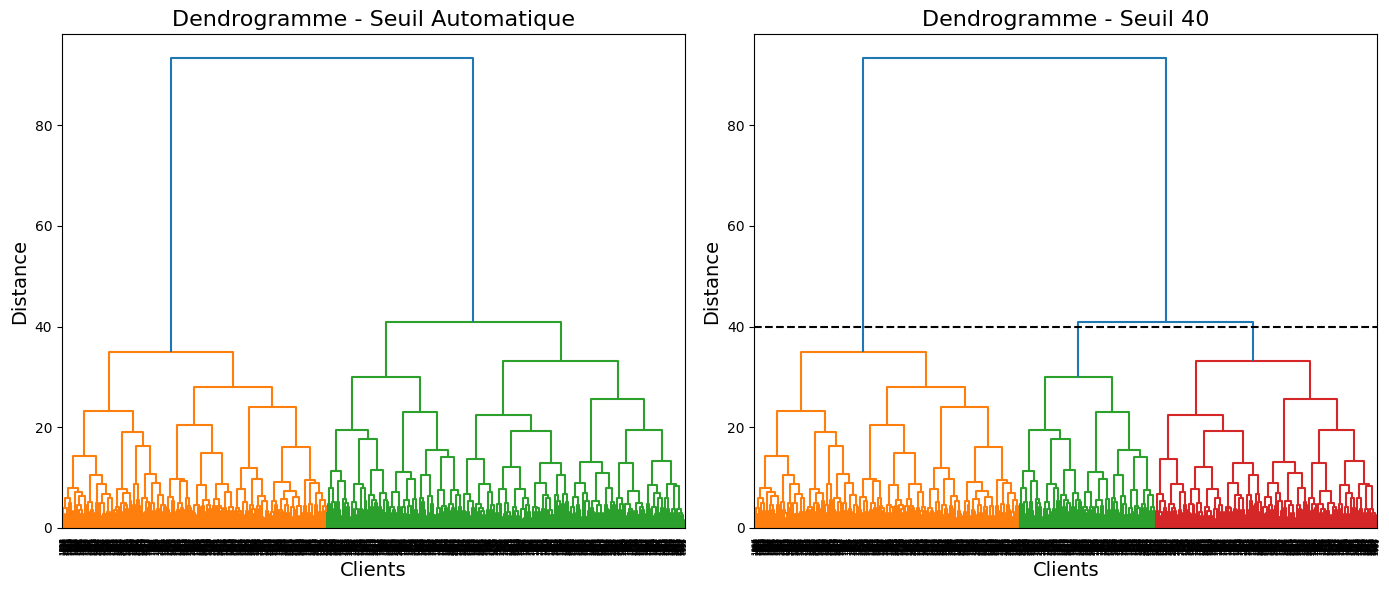

In [29]:
# Matrice de linkage
linkage_matrix = linkage(data_encoded, method='ward')

# Création de la figure avec 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Premier subplot : dendrogramme avec le seuil automatique (sans color_threshold)
dendrogram(linkage_matrix, ax=axs[0])
axs[0].set_title("Dendrogramme - Seuil Automatique", fontsize=16)
axs[0].set_xlabel("Clients", fontsize=14)
axs[0].set_ylabel("Distance", fontsize=14)

# Deuxième subplot : dendrogramme avec color_threshold=40
dendrogram(linkage_matrix, color_threshold=40, ax=axs[1])
axs[1].axhline(y=40, color='black', linestyle='--')
axs[1].set_title("Dendrogramme - Seuil 40", fontsize=16)
axs[1].set_xlabel("Clients", fontsize=14)
axs[1].set_ylabel("Distance", fontsize=14)

# Ajustement de l'affichage
plt.tight_layout()
plt.show()

Le dendrogramme obtenu à partir de la matrice de **linkage** montre la hiérarchie des regroupements des clients, où chaque client est initialement traité comme un cluster individuel, et les clusters sont ensuite fusionnés selon leur similarité. Sans spécification de seuil, le dendrogramme (celui de gauche) suggère automatiquement deux clusters.

Cependant, en observant plus en détail, on remarque que le cluster à droite (en rouge) semble comporter deux sous-ensembles distincts, ce qui pourrait justifier de les séparer davantage. Pour cela, nous avons choisi de fixer un seuil à **40**, permettant de distinguer trois clusters. Cela suggère une segmentation en trois groupes de clients, bien que les clusters 2 et 3 puissent partager certaines caractéristiques similaires.


## 2.2. Interptétation des clusters


In [30]:
data["Cluster_CAH"] =  fcluster(linkage_matrix, t=3, criterion='maxclust')

In [31]:
print("Nombre de clients par cluster : \n")
for cluster, count in data["Cluster_CAH"].value_counts().items():
    print(f"Cluster {cluster}: {count} clients")

Nombre de clients par cluster : 

Cluster 1: 905 clients
Cluster 3: 756 clients
Cluster 2: 463 clients


Les graphiques suivant permettront d'identifier les particularités de chaque cluster

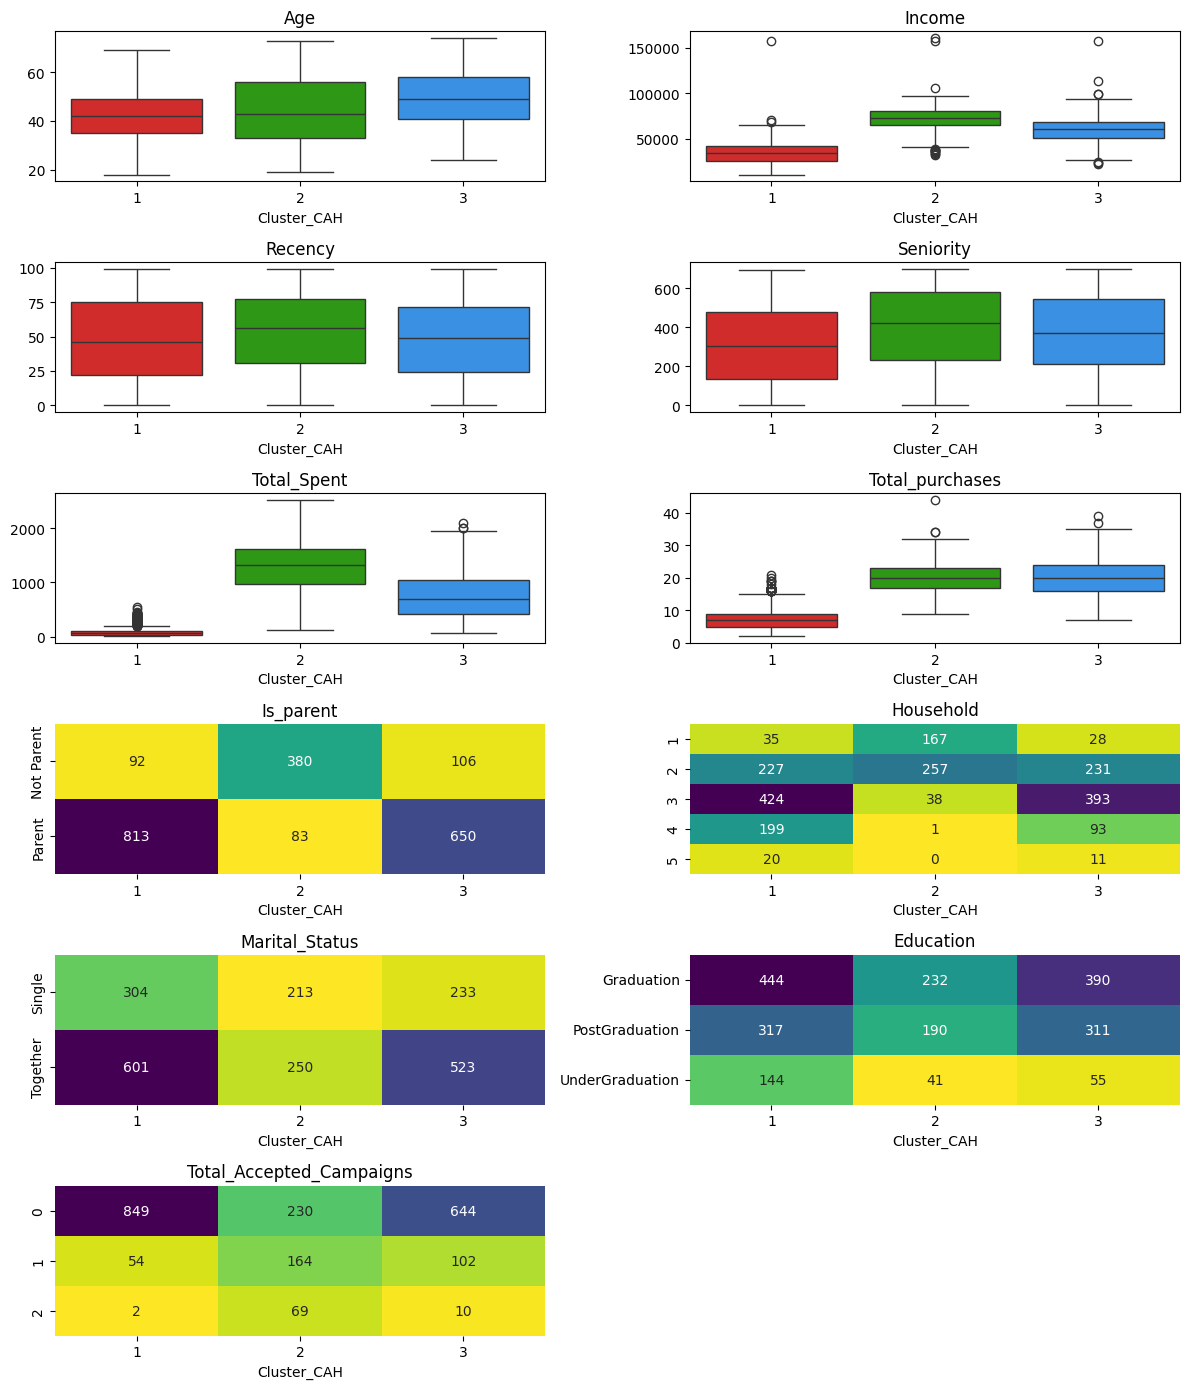

In [32]:
vars_names = ['Age', 'Income', 'Recency', 'Seniority', 'Total_Spent', 'Total_purchases']
fig, ax = plt.subplots(6, 2, figsize=(12, 14))
ax_flat = ax.flatten()

palette = sns.color_palette(["#ec1010", "#21ac00", "#1E90FF"]) 
for num, var in enumerate(vars_names, 1):
    sns.boxplot(data=data, x="Cluster_CAH", y=var, ax=ax_flat[num-1], hue="Cluster_CAH", palette=palette)
    ax_flat[num-1].set_ylabel(None)
    ax_flat[num-1].set_title(f"{var}")
    ax_flat[num-1].legend().set_visible(False) 

categorical_vars = ["Is_parent", "Household", "Marital_Status", "Education", "Total_Accepted_Campaigns"]
for num, var in enumerate(categorical_vars, start=len(vars_names) + 1):
    contingency_table = pd.crosstab(data[var], data['Cluster_CAH'])
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="viridis_r", cbar=False, ax=ax_flat[num-1])
    ax_flat[num-1].set_ylabel(None)
    ax_flat[num-1].set_title(f"{var}")

ax_flat[-1].axis('off')

plt.tight_layout()
plt.show()

## Cluster 1 (en rouge): **Familles Modestes et Réservées**
- **Revenus** : Modestes, les plus bas parmi les clusters.
- **Achats** : Faibles en montant et en fréquence. Ce groupe effectue peu d'achats, en particulier en ligne.
- **Acceptation des campagnes** : Faible (moins de 20% acceptent les offres de campagne).
- **Profil familial** : 
  - 90% sont parents.
  - 66% vivent en couple.
  - Près de 50% vivent à trois sous le même toit, et 96% à plus de deux.
- **Insights marketing** : Ce groupe semble sensible au prix et recherche probablement des offres abordables et des promotions familiales.

---

## Cluster 3 (en bleu) : **Couples Haut Revenus et Opportunistes**
- **Revenus** : Élevés, légèrement inférieurs au Cluster 2.
- **Achats** : Dépensent beaucoup en montant et effectuent plusieurs achats.
- **Acceptation des campagnes** : Faible (moins de 30% acceptent les offres de campagne).
- **Profil familial** : 
  - 85% sont parents.
  - 70% vivent en couple.
  - Majoritairement, ils vivent dans des foyers de taille moyenne (moins de trois personnes).
- **Insights marketing** : Ce segment est un excellent public pour des **offres premium pour familles**, mais il pourrait nécessiter des campagnes très ciblées pour augmenter l'engagement.

---

## Cluster 2 (en vert): **Professionnels Solitaires et Réactifs**
- **Revenus** : Les plus élevés parmi les trois clusters.
- **Achats** : Dépensent le plus en montant total et effectuent de nombreux achats.
- **Acceptation des campagnes** : Forte acceptation des offres (environ 60% acceptent les campagnes).
- **Profil familial** : 
  - 82% sont non-parents.
  - 64% vivent en couple.
  - Près de 92% vivent seuls ou à deux dans le foyer.
- **Insights marketing** : Ce segment est réactif aux campagnes marketing et représente une cible clé pour des **offres haut de gamme**, des services personnalisés et des promotions exclusives.

---

## Comparaison globale des clusters (en chiffres)

| **Cluster**                     | **Revenus**         | **Achats (Montant)** | **Achats (Fréquence)** | **Acceptation des Campagnes** | **Profil Familial**             |  
|----------------------------------|---------------------|----------------------|------------------------|------------------------------|----------------------------------|  
| **Familles Modestes et Réservées** | Modestes            | Faibles              | Faibles                | < 7%                        | 90% parents, 66% en couple      |  
| **Couples Haut Revenus et Opportunistes** | Élevés            | Élevés               | Élevés                 | < 15%                        | 85% parents, 70% en couple      |  
| **Professionnels Solitaires et Réactifs** | Très élevés       | Très élevés          | Très fréquents         | ~60%                         | 82% non-parents, 64% en couple  |  

---


